In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from datasets import load_dataset
from transformers import T5TokenizerFast, get_scheduler, SwitchTransformersForConditionalGeneration, AutoTokenizer
from torch.utils.data import DataLoader

from mcsmoe.save_model import eval_data_process
from mcsmoe.data import EXTRA_KEYS_FOR_EVAL

/home/wazenmai/Multimodal/env_dir/mc_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
checkpoint = "/home/wazenmai/Warehouse/NLP/checkpoints/sky_ckpts/switch-32e-mrpc-fine/best" # {'accuracy': 0.8553921568627451, 'f1': 0.8984509466437176, 'loss': 2.0424006496156966}
checkpoint = "/home/wazenmai/Warehouse/NLP/checkpoints/mc-smoe/test/switch-8e-mrpc-test1-5/best" # {'accuracy': 0.8799, 'f1': 0.9160}
model_name = "google/switch-base-8" # 32
num_experts = 8
task = "mrpc"
preprocessing_num_workers = 8
per_device_eval_batch_size = 64
_idx = 1

In [4]:
model = SwitchTransformersForConditionalGeneration.from_pretrained(checkpoint)
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    use_fast=True,
    use_auth_token=None,
)
eval_dataloader, evaluate_fn = eval_data_process(task, tokenizer)

Map (num_proc=8): 100%|██████████████| 408/408 [00:00<00:00, 1377.74 examples/s]


Number of validation examples: 408


In [6]:
model.eval()
expert_indexes = [[] for i in range(6)]
decoder_expert_indexes = [[] for i in range(6)]
encoder_logits = [[] for i in range(6)]
decoder_logits = [[] for i in range(6)]
for eval_step, eval_batch in enumerate(eval_dataloader):
    extra_keys_eval_batch = {}
    for key in list(eval_batch.keys()):
        if key in EXTRA_KEYS_FOR_EVAL:
            extra_keys_eval_batch[key] = eval_batch.pop(key)
    with torch.no_grad():
        outputs = model(**eval_batch)
        router_tuples = outputs.encoder_router_logits
        decoder_router_tuples = outputs.decoder_router_logits
        for _idx in range(1, 12, 2):
            router_logits, ei = router_tuples[_idx]
            expert_indexes[_idx // 2].append(ei.flatten().cpu().numpy())
            encoder_logits[_idx // 2].append(torch.nn.functional.softmax(router_logits, dim=-1).cpu().numpy())
            router_logits, ei = decoder_router_tuples[_idx]
            decoder_expert_indexes[_idx // 2].append(ei.flatten().cpu().numpy())
            decoder_logits[_idx // 2].append(torch.nn.functional.softmax(router_logits, dim=-1).cpu().numpy())
for _idx in range(6):
    expert_indexes[_idx] = np.concatenate(expert_indexes[_idx])
    decoder_expert_indexes[_idx] = np.concatenate(decoder_expert_indexes[_idx])
encoder_expert = np.stack(expert_indexes, axis=0)
decoder_expert = np.stack(decoder_expert_indexes, axis=0)
print(encoder_expert.shape, encoder_expert)
print(decoder_expert.shape, decoder_expert)

(6, 47040) [[7 6 4 ... 4 4 4]
 [0 1 2 ... 2 2 2]
 [2 2 3 ... 3 3 3]
 [2 1 2 ... 4 4 4]
 [5 7 6 ... 2 2 2]
 [3 0 4 ... 7 7 7]]
(6, 816) [[1 3 0 ... 4 1 3]
 [6 7 6 ... 2 6 3]
 [3 7 3 ... 0 3 2]
 [7 7 7 ... 7 7 7]
 [0 0 5 ... 0 0 0]
 [7 7 7 ... 7 7 7]]


In [7]:
def convert_logits2np(input_data, num_expert, num_layer):
    # input_data(6, 7, 64, 112, 32) = (L, #B, B, T, E) -> (L, #B, B*T, E) -> (L, #B, E)
    output_array = np.zeros((num_layer, num_expert))
    for _idx in range(num_layer):
        temp = []
        for b in range(len(input_data[_idx])):
            ele = input_data[_idx][b]
            new_ele = ele.reshape(ele.shape[0] * ele.shape[1], ele.shape[2])
            s = np.sum(new_ele, axis=0) / new_ele.shape[0]
            temp.append(s)
        s_b = np.sum(temp, axis=0) / len(temp)
        output_array[_idx] = s_b
    print(output_array.shape)
    return output_array

In [8]:
encoder_logits_np = convert_logits2np(encoder_logits, num_experts, 6)
decoder_logits_np = convert_logits2np(decoder_logits, num_experts, 6)

(6, 8)
(6, 8)


In [9]:
mean_router_logits = freq = np.concatenate([encoder_logits_np, decoder_logits_np])
mean_router_logits.shape

(12, 8)

In [6]:
num_experts = expert_index.max() + 1
print(num_experts)

32


In [10]:
expert_frequencies = np.bincount(expert_index, minlength=num_experts)
print(expert_frequencies)

NameError: name 'expert_index' is not defined

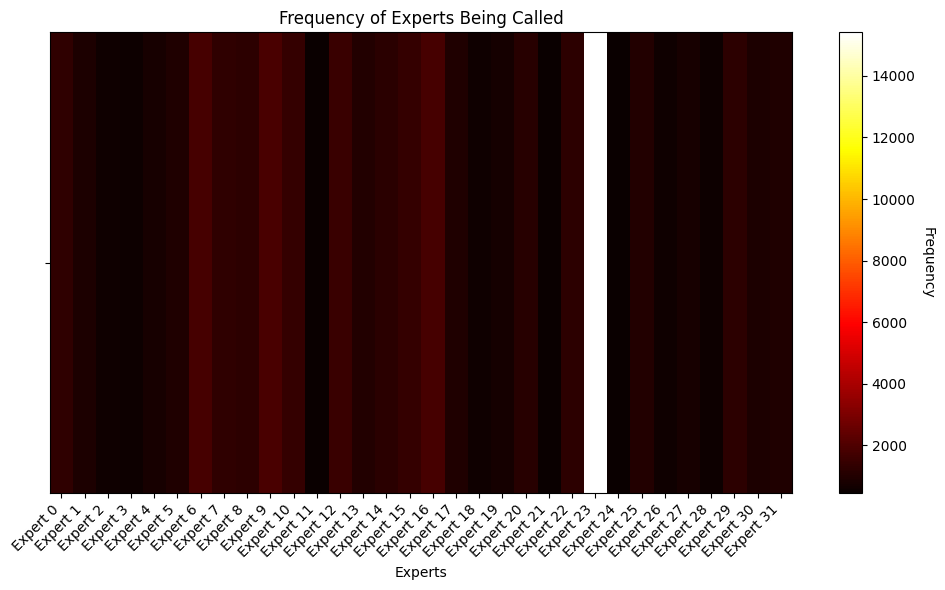

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))
# im = ax.imshow(expert_frequencies[None, :], cmap='hot', aspect='auto')

# cbar = ax.figure.colorbar(im, ax=ax)
# cbar.ax.set_ylabel('Frequency', rotation=-90, va="bottom")

ax.set_xticks(np.arange(num_experts))
ax.set_yticks([0])
ax.set_xticklabels([f'Expert {i}' for i in range(num_experts)], rotation=45, ha='right')
ax.set_yticklabels([''])

# Set the title and axis labels
ax.set_title('Frequency of Experts Being Called')
ax.set_xlabel('Experts')

# Adjust the layout and save the plot
plt.tight_layout()
# plt.savefig('expert_frequency_heatmap.png', dpi=300, bbox_inches='tight')

# Optionally, you can also show the plot
plt.show()

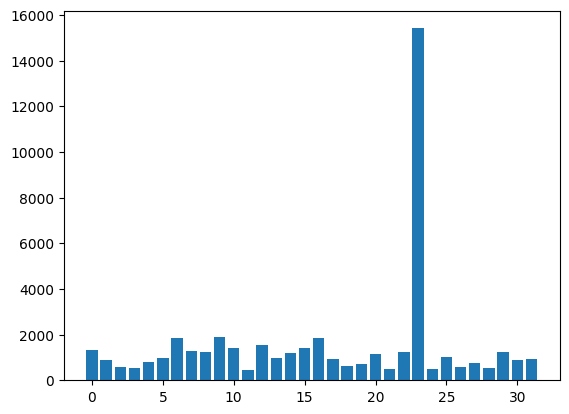

In [11]:
fig, ax = plt.subplots()
ax.bar(np.arange(num_experts), expert_frequencies)
plt.show()

In [12]:
# encoder_expert, decoder_expert
def get_freq(layer_expert_index, num_expert):
    freq = np.zeros((layer_expert_index.shape[0], num_expert))
    for layer_idx, layer_expert_index in enumerate(layer_expert_index):
        freq[layer_idx] = np.bincount(layer_expert_index, minlength=num_expert)
    return freq

encoder_freq = get_freq(encoder_expert, num_experts)
decoder_freq = get_freq(decoder_expert, num_experts)
print(encoder_freq.shape, decoder_freq.shape)

(6, 8) (6, 8)


In [13]:
freq = np.concatenate([encoder_freq, decoder_freq])
print(freq.shape)
total_activations = freq.sum(axis=1, keepdims=True)
expert_frequencies_percentage = (freq / total_activations) * 100
expert_frequencies = expert_frequencies_percentage
print(expert_frequencies.shape, expert_frequencies)

(12, 8)
(12, 8) [[  6.68154762   7.65943878  12.08120748   7.42559524  41.72193878
    6.29251701   7.62542517  10.51232993]
 [  8.27168367  26.37329932  21.83248299   7.8082483    7.22151361
    8.25255102  10.06802721  10.17219388]
 [  5.25935374   7.33205782  11.08630952  23.04209184   9.16028912
   14.38562925   7.2172619   22.5170068 ]
 [  5.70365646  11.53911565  12.92091837   4.45578231  36.52210884
   12.24064626   4.3452381   12.27253401]
 [ 10.72704082   6.11607143  32.94005102   8.07185374   1.23937075
    3.20790816  33.32908163   4.36862245]
 [  3.52891156   2.57865646   6.13520408   6.97704082  32.1747449
    4.49617347   5.6122449   38.49702381]
 [ 21.20098039  28.79901961   0.          34.19117647  15.80882353
    0.           0.           0.        ]
 [  0.49019608   5.14705882  15.31862745   7.84313725   0.
    0.24509804  50.12254902  20.83333333]
 [ 12.5          0.          10.78431373  47.91666667   1.83823529
    0.49019608   0.          26.47058824]
 [  0.      

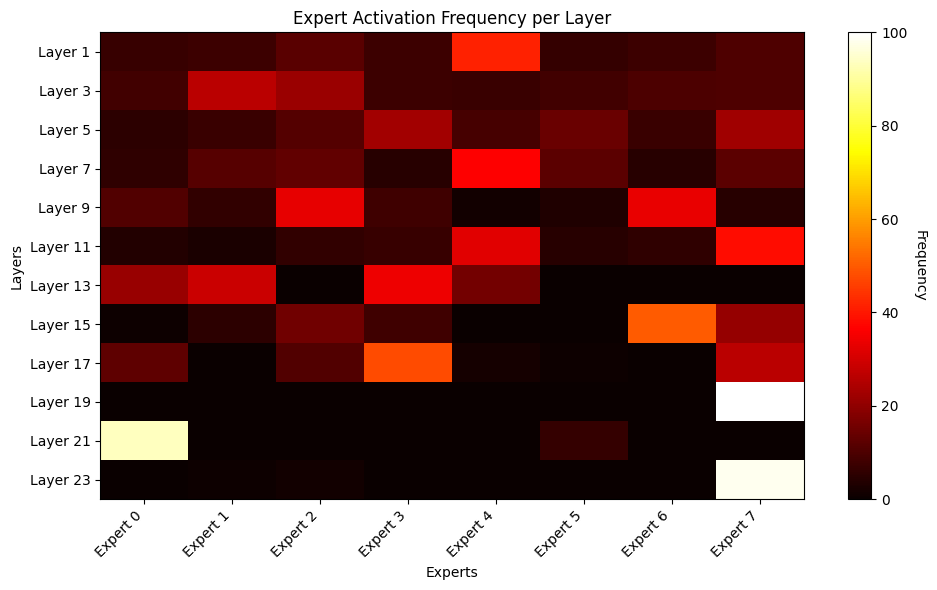

In [14]:


# Assuming you have the expert_index tensor from the model output
# expert_index.shape = (num_layers, num_tokens)

# Calculate the frequency of each expert being called for each layer
# expert_frequencies = np.zeros((expert_index.shape[0], expert_index.max() + 1))
# for layer_idx, layer_expert_index in enumerate(expert_index):
#     expert_frequencies[layer_idx] = np.bincount(layer_expert_index, minlength=expert_index.max() + 1)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create the heatmap
im = ax.imshow(expert_frequencies, cmap='hot', aspect='auto')

# Set the colorbar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Frequency', rotation=-90, va="bottom")

# Set the x and y ticks
ax.set_xticks(np.arange(expert_frequencies.shape[1]))
ax.set_yticks(np.arange(expert_frequencies.shape[0]))
ax.set_xticklabels([f'Expert {i}' for i in range(expert_frequencies.shape[1])], rotation=45, ha='right')
ax.set_yticklabels([f'Layer {i}' for i in range(1, expert_frequencies.shape[0] * 2, 2)])

# Set the title and axis labels
ax.set_title('Expert Activation Frequency per Layer')
ax.set_xlabel('Experts')
ax.set_ylabel('Layers')

# Adjust the layout and save the plot
plt.tight_layout()
# plt.savefig('expert_activation_heatmap.png', dpi=300, bbox_inches='tight')

# Optionally, you can also show the plot
plt.show()

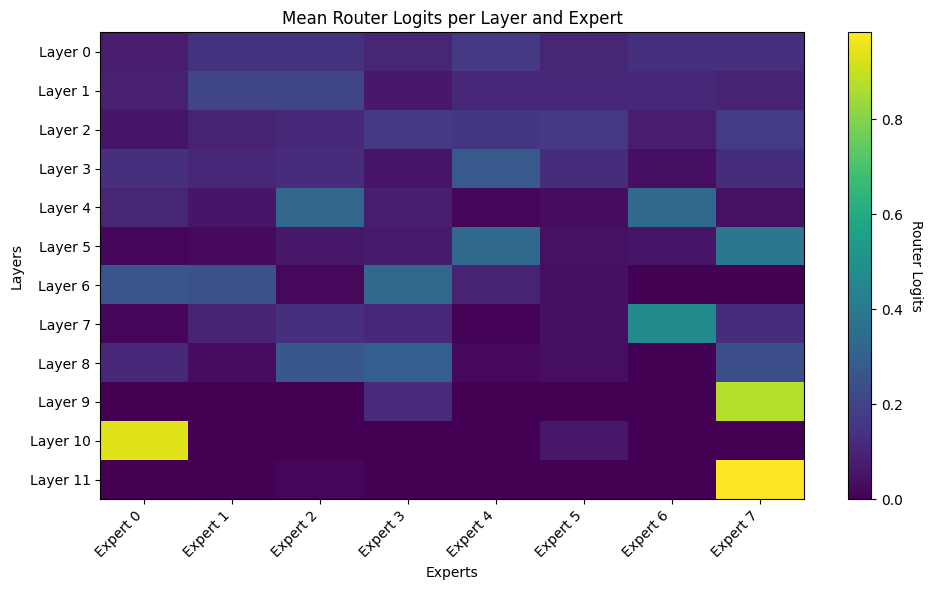

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have the router_logits array from the model output
# router_logits.shape = (num_layers, num_tokens, num_experts)

# Calculate the mean router logits for each layer and expert combination
# mean_router_logits = np.mean(router_logits, axis=1)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create the heatmap
im = ax.imshow(mean_router_logits, cmap='viridis', aspect='auto')

# Set the colorbar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Router Logits', rotation=-90, va="bottom")

# Set the x and y ticks
ax.set_xticks(np.arange(mean_router_logits.shape[1]))
ax.set_yticks(np.arange(mean_router_logits.shape[0]))
ax.set_xticklabels([f'Expert {i}' for i in range(mean_router_logits.shape[1])], rotation=45, ha='right')
ax.set_yticklabels([f'Layer {i}' for i in range(mean_router_logits.shape[0])])

# Set the title and axis labels
ax.set_title('Mean Router Logits per Layer and Expert')
ax.set_xlabel('Experts')
ax.set_ylabel('Layers')

# Adjust the layout and save the plot
plt.tight_layout()
plt.savefig('router_logits_heatmap.png', dpi=300, bbox_inches='tight')

# Optionally, you can also show the plot
# plt.show()